In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""
fpi = 10

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                        | 0/50000 [00:00<?, ?it/s]

  9%|█████████▉                                                                                                | 4697/50000 [00:00<00:00, 46957.17it/s]

 19%|███████████████████▉                                                                                      | 9431/50000 [00:00<00:00, 47178.79it/s]

 28%|█████████████████████████████▊                                                                           | 14199/50000 [00:00<00:00, 47406.16it/s]

 38%|███████████████████████████████████████▊                                                                 | 18969/50000 [00:00<00:00, 47520.92it/s]

 48%|█████████████████████████████████████████████████▉                                                       | 23761/50000 [00:00<00:00, 47660.94it/s]

 57%|███████████████████████████████████████████████████████████▉                                             | 28538/50000 [00:00<00:00, 47696.49it/s]

 67%|█████████████████████████████████████████████████████████████████████▉                                   | 33308/50000 [00:00<00:00, 47681.04it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▉                         | 38077/50000 [00:00<00:00, 47663.15it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 42849/50000 [00:00<00:00, 47678.44it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 47619/50000 [00:01<00:00, 47684.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 47593.44it/s]

Files already downloaded and verified


  0%|                                                                                                                        | 0/10000 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████▌                                                        | 4681/10000 [00:00<00:00, 46799.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9361/10000 [00:00<00:00, 46740.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 46643.85it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 pnigdeyr


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-pnigdeyr:best, 58.53MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:4.7


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                          | 0/157 [00:00<?, ?it/s]

  1%|▋                                                                                                                 | 1/157 [00:00<01:44,  1.49it/s]

  2%|██▏                                                                                                               | 3/157 [00:00<00:34,  4.46it/s]

  3%|███▋                                                                                                              | 5/157 [00:00<00:21,  6.98it/s]

  4%|█████                                                                                                             | 7/157 [00:01<00:16,  9.00it/s]

  6%|██████▌                                                                                                           | 9/157 [00:01<00:13, 10.57it/s]

  7%|███████▉                                                                                                         | 11/157 [00:01<00:12, 11.77it/s]

  8%|█████████▎                                                                                                       | 13/157 [00:01<00:11, 12.67it/s]

 10%|██████████▊                                                                                                      | 15/157 [00:01<00:10, 13.33it/s]

 11%|████████████▏                                                                                                    | 17/157 [00:01<00:10, 13.80it/s]

 12%|█████████████▋                                                                                                   | 19/157 [00:01<00:09, 14.12it/s]

 13%|███████████████                                                                                                  | 21/157 [00:02<00:09, 14.36it/s]

 15%|████████████████▌                                                                                                | 23/157 [00:02<00:09, 14.53it/s]

 16%|█████████████████▉                                                                                               | 25/157 [00:02<00:09, 14.66it/s]

 17%|███████████████████▍                                                                                             | 27/157 [00:02<00:08, 14.74it/s]

 18%|████████████████████▊                                                                                            | 29/157 [00:02<00:08, 14.79it/s]

 20%|██████████████████████▎                                                                                          | 31/157 [00:02<00:08, 14.84it/s]

 21%|███████████████████████▊                                                                                         | 33/157 [00:02<00:08, 14.87it/s]

 22%|█████████████████████████▏                                                                                       | 35/157 [00:02<00:08, 14.89it/s]

 24%|██████████████████████████▋                                                                                      | 37/157 [00:03<00:08, 14.91it/s]

 25%|████████████████████████████                                                                                     | 39/157 [00:03<00:07, 14.90it/s]

 26%|█████████████████████████████▌                                                                                   | 41/157 [00:03<00:07, 14.91it/s]

 27%|██████████████████████████████▉                                                                                  | 43/157 [00:03<00:07, 14.92it/s]

 29%|████████████████████████████████▍                                                                                | 45/157 [00:03<00:07, 14.93it/s]

 30%|█████████████████████████████████▊                                                                               | 47/157 [00:03<00:07, 14.92it/s]

 31%|███████████████████████████████████▎                                                                             | 49/157 [00:03<00:07, 14.92it/s]

 32%|████████████████████████████████████▋                                                                            | 51/157 [00:04<00:07, 14.93it/s]

 34%|██████████████████████████████████████▏                                                                          | 53/157 [00:04<00:06, 14.93it/s]

 35%|███████████████████████████████████████▌                                                                         | 55/157 [00:04<00:06, 14.94it/s]

 36%|█████████████████████████████████████████                                                                        | 57/157 [00:04<00:06, 14.93it/s]

 38%|██████████████████████████████████████████▍                                                                      | 59/157 [00:04<00:06, 14.86it/s]

 39%|███████████████████████████████████████████▉                                                                     | 61/157 [00:04<00:06, 14.16it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 63/157 [00:04<00:06, 13.75it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 65/157 [00:05<00:06, 13.47it/s]

 43%|████████████████████████████████████████████████▏                                                                | 67/157 [00:05<00:06, 13.32it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 69/157 [00:05<00:06, 13.19it/s]

 45%|███████████████████████████████████████████████████                                                              | 71/157 [00:05<00:06, 13.09it/s]

 46%|████████████████████████████████████████████████████▌                                                            | 73/157 [00:05<00:06, 13.11it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 75/157 [00:05<00:06, 13.40it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 77/157 [00:05<00:05, 13.83it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 79/157 [00:06<00:05, 14.13it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 81/157 [00:06<00:05, 13.80it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 83/157 [00:06<00:05, 13.50it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 85/157 [00:06<00:05, 13.57it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 87/157 [00:06<00:05, 12.06it/s]

 57%|████████████████████████████████████████████████████████████████                                                 | 89/157 [00:06<00:05, 12.55it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 91/157 [00:07<00:05, 12.57it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 93/157 [00:07<00:05, 12.71it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 95/157 [00:07<00:05, 11.59it/s]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 97/157 [00:07<00:05, 10.01it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 99/157 [00:07<00:06,  9.17it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                        | 100/157 [00:08<00:06,  8.88it/s]

 64%|████████████████████████████████████████████████████████████████████████                                        | 101/157 [00:08<00:06,  8.58it/s]

 65%|████████████████████████████████████████████████████████████████████████▊                                       | 102/157 [00:08<00:06,  8.35it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                      | 103/157 [00:08<00:06,  8.15it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                     | 104/157 [00:08<00:06,  8.00it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                     | 105/157 [00:08<00:06,  7.93it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                    | 106/157 [00:08<00:06,  7.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                   | 107/157 [00:08<00:06,  7.80it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                   | 108/157 [00:09<00:06,  7.73it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                  | 109/157 [00:09<00:06,  7.71it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 110/157 [00:09<00:06,  7.71it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                                | 111/157 [00:09<00:05,  7.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                | 112/157 [00:09<00:05,  7.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▌                               | 113/157 [00:09<00:05,  7.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                              | 114/157 [00:09<00:05,  7.75it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████                              | 115/157 [00:09<00:05,  7.72it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▊                             | 116/157 [00:10<00:05,  7.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                            | 117/157 [00:10<00:05,  7.69it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▏                           | 118/157 [00:10<00:05,  7.74it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                           | 119/157 [00:10<00:04,  7.76it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                          | 120/157 [00:10<00:04,  7.79it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▎                         | 121/157 [00:10<00:04,  7.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                         | 122/157 [00:10<00:04,  7.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                        | 123/157 [00:11<00:04,  7.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▍                       | 124/157 [00:11<00:04,  7.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                      | 125/157 [00:11<00:04,  7.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                      | 126/157 [00:11<00:03,  8.02it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▌                     | 127/157 [00:11<00:03,  8.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                    | 128/157 [00:11<00:03,  8.07it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████                    | 129/157 [00:11<00:03,  8.06it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                   | 130/157 [00:11<00:03,  7.88it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                  | 131/157 [00:12<00:03,  7.94it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▏                 | 132/157 [00:12<00:03,  7.94it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                 | 133/157 [00:12<00:03,  7.97it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                | 134/157 [00:12<00:02,  8.00it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 135/157 [00:12<00:02,  8.01it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████               | 136/157 [00:12<00:02,  7.96it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 137/157 [00:12<00:02,  7.92it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▍             | 138/157 [00:12<00:02,  7.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏            | 139/157 [00:13<00:02,  7.98it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▊            | 140/157 [00:13<00:02,  8.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 141/157 [00:13<00:01,  8.02it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 142/157 [00:13<00:01,  8.02it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████          | 143/157 [00:13<00:01,  8.02it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 144/157 [00:13<00:01,  7.94it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 145/157 [00:13<00:01,  7.98it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 146/157 [00:13<00:01,  7.95it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 147/157 [00:14<00:01,  7.93it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 148/157 [00:14<00:01,  7.91it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 149/157 [00:14<00:01,  7.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████     | 150/157 [00:14<00:00,  7.93it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 151/157 [00:14<00:00,  7.98it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 152/157 [00:14<00:00,  7.99it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 153/157 [00:14<00:00,  7.95it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [00:14<00:00,  7.97it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [00:15<00:00,  8.00it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [00:15<00:00,  7.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:15<00:00,  8.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.28it/s]

train - OK


  0%|                                                                                                                           | 0/40 [00:00<?, ?it/s]

  2%|██▉                                                                                                                | 1/40 [00:00<00:08,  4.76it/s]

  5%|█████▊                                                                                                             | 2/40 [00:00<00:06,  6.13it/s]

  8%|████████▋                                                                                                          | 3/40 [00:00<00:05,  6.90it/s]

 10%|███████████▌                                                                                                       | 4/40 [00:00<00:04,  7.33it/s]

 12%|██████████████▍                                                                                                    | 5/40 [00:00<00:04,  7.58it/s]

 15%|█████████████████▎                                                                                                 | 6/40 [00:00<00:04,  7.74it/s]

 18%|████████████████████▏                                                                                              | 7/40 [00:00<00:04,  7.84it/s]

 20%|███████████████████████                                                                                            | 8/40 [00:01<00:04,  7.92it/s]

 22%|█████████████████████████▉                                                                                         | 9/40 [00:01<00:03,  7.97it/s]

 25%|████████████████████████████▌                                                                                     | 10/40 [00:01<00:03,  7.91it/s]

 28%|███████████████████████████████▎                                                                                  | 11/40 [00:01<00:03,  7.96it/s]

 30%|██████████████████████████████████▏                                                                               | 12/40 [00:01<00:03,  8.00it/s]

 32%|█████████████████████████████████████                                                                             | 13/40 [00:01<00:03,  8.02it/s]

 35%|███████████████████████████████████████▉                                                                          | 14/40 [00:01<00:03,  8.05it/s]

 38%|██████████████████████████████████████████▊                                                                       | 15/40 [00:01<00:03,  8.06it/s]

 40%|█████████████████████████████████████████████▌                                                                    | 16/40 [00:02<00:02,  8.07it/s]

 42%|████████████████████████████████████████████████▍                                                                 | 17/40 [00:02<00:02,  8.07it/s]

 45%|███████████████████████████████████████████████████▎                                                              | 18/40 [00:02<00:02,  7.98it/s]

 48%|██████████████████████████████████████████████████████▏                                                           | 19/40 [00:02<00:02,  8.02it/s]

 50%|█████████████████████████████████████████████████████████                                                         | 20/40 [00:02<00:02,  8.04it/s]

 52%|███████████████████████████████████████████████████████████▊                                                      | 21/40 [00:02<00:02,  8.05it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                   | 22/40 [00:02<00:02,  8.06it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                | 23/40 [00:02<00:02,  8.03it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                             | 24/40 [00:03<00:01,  8.03it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                          | 25/40 [00:03<00:01,  7.96it/s]

 65%|██████████████████████████████████████████████████████████████████████████                                        | 26/40 [00:03<00:01,  8.00it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                     | 27/40 [00:03<00:01,  8.03it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 28/40 [00:03<00:01,  8.04it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                               | 29/40 [00:03<00:01,  8.05it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 30/40 [00:03<00:01,  8.06it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 31/40 [00:03<00:01,  8.06it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 32/40 [00:04<00:00,  8.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 33/40 [00:04<00:00,  7.98it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 34/40 [00:04<00:00,  8.01it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 35/40 [00:04<00:00,  8.04it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 36/40 [00:04<00:00,  8.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 37/40 [00:04<00:00,  8.05it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 38/40 [00:04<00:00,  8.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [00:04<00:00,  8.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.93it/s]

val - OK


  0%|                                                                                                                           | 0/40 [00:00<?, ?it/s]

  2%|██▉                                                                                                                | 1/40 [00:00<00:08,  4.76it/s]

  5%|█████▊                                                                                                             | 2/40 [00:00<00:06,  6.22it/s]

  8%|████████▋                                                                                                          | 3/40 [00:00<00:05,  6.91it/s]

 10%|███████████▌                                                                                                       | 4/40 [00:00<00:04,  7.33it/s]

 12%|██████████████▍                                                                                                    | 5/40 [00:00<00:04,  7.49it/s]

 15%|█████████████████▎                                                                                                 | 6/40 [00:00<00:04,  7.68it/s]

 18%|████████████████████▏                                                                                              | 7/40 [00:00<00:04,  7.81it/s]

 20%|███████████████████████                                                                                            | 8/40 [00:01<00:04,  7.89it/s]

 22%|█████████████████████████▉                                                                                         | 9/40 [00:01<00:03,  7.95it/s]

 25%|████████████████████████████▌                                                                                     | 10/40 [00:01<00:03,  8.00it/s]

 28%|███████████████████████████████▎                                                                                  | 11/40 [00:01<00:03,  8.03it/s]

 30%|██████████████████████████████████▏                                                                               | 12/40 [00:01<00:03,  8.04it/s]

 32%|█████████████████████████████████████                                                                             | 13/40 [00:01<00:03,  7.97it/s]

 35%|███████████████████████████████████████▉                                                                          | 14/40 [00:01<00:03,  8.01it/s]

 38%|██████████████████████████████████████████▊                                                                       | 15/40 [00:01<00:03,  8.04it/s]

 40%|█████████████████████████████████████████████▌                                                                    | 16/40 [00:02<00:02,  8.05it/s]

 42%|████████████████████████████████████████████████▍                                                                 | 17/40 [00:02<00:02,  8.06it/s]

 45%|███████████████████████████████████████████████████▎                                                              | 18/40 [00:02<00:02,  8.07it/s]

 48%|██████████████████████████████████████████████████████▏                                                           | 19/40 [00:02<00:02,  8.07it/s]

 50%|█████████████████████████████████████████████████████████                                                         | 20/40 [00:02<00:02,  8.07it/s]

 52%|███████████████████████████████████████████████████████████▊                                                      | 21/40 [00:02<00:02,  7.99it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                   | 22/40 [00:02<00:02,  8.02it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                | 23/40 [00:02<00:02,  8.05it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                             | 24/40 [00:03<00:01,  8.06it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                          | 25/40 [00:03<00:01,  8.06it/s]

 65%|██████████████████████████████████████████████████████████████████████████                                        | 26/40 [00:03<00:01,  8.07it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                     | 27/40 [00:03<00:01,  8.07it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 28/40 [00:03<00:01,  8.07it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                               | 29/40 [00:03<00:01,  7.99it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 30/40 [00:03<00:01,  8.02it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 31/40 [00:03<00:01,  8.05it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 32/40 [00:04<00:00,  8.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 33/40 [00:04<00:00,  8.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 34/40 [00:04<00:00,  8.07it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 35/40 [00:04<00:00,  8.07it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 36/40 [00:04<00:00,  8.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 37/40 [00:04<00:00,  7.99it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 38/40 [00:04<00:00,  8.02it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [00:04<00:00,  8.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.01it/s]

test InD - OK


  0%|                                                                                                                           | 0/40 [00:00<?, ?it/s]

  2%|██▉                                                                                                                | 1/40 [00:00<00:08,  4.60it/s]

  5%|█████▊                                                                                                             | 2/40 [00:00<00:06,  6.15it/s]

  8%|████████▋                                                                                                          | 3/40 [00:00<00:05,  6.90it/s]

 10%|███████████▌                                                                                                       | 4/40 [00:00<00:04,  7.32it/s]

 12%|██████████████▍                                                                                                    | 5/40 [00:00<00:04,  7.57it/s]

 15%|█████████████████▎                                                                                                 | 6/40 [00:00<00:04,  7.74it/s]

 18%|████████████████████▏                                                                                              | 7/40 [00:00<00:04,  7.85it/s]

 20%|███████████████████████                                                                                            | 8/40 [00:01<00:04,  7.83it/s]

 22%|█████████████████████████▉                                                                                         | 9/40 [00:01<00:03,  7.91it/s]

 25%|████████████████████████████▌                                                                                     | 10/40 [00:01<00:03,  7.97it/s]

 28%|███████████████████████████████▎                                                                                  | 11/40 [00:01<00:03,  8.00it/s]

 30%|██████████████████████████████████▏                                                                               | 12/40 [00:01<00:03,  8.02it/s]

 32%|█████████████████████████████████████                                                                             | 13/40 [00:01<00:03,  8.04it/s]

 35%|███████████████████████████████████████▉                                                                          | 14/40 [00:01<00:03,  8.05it/s]

 38%|██████████████████████████████████████████▊                                                                       | 15/40 [00:01<00:03,  8.06it/s]

 40%|█████████████████████████████████████████████▌                                                                    | 16/40 [00:02<00:03,  7.98it/s]

 42%|████████████████████████████████████████████████▍                                                                 | 17/40 [00:02<00:02,  8.01it/s]

 45%|███████████████████████████████████████████████████▎                                                              | 18/40 [00:02<00:02,  8.04it/s]

 48%|██████████████████████████████████████████████████████▏                                                           | 19/40 [00:02<00:02,  8.05it/s]

 50%|█████████████████████████████████████████████████████████                                                         | 20/40 [00:02<00:02,  8.06it/s]

 52%|███████████████████████████████████████████████████████████▊                                                      | 21/40 [00:02<00:02,  8.06it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                   | 22/40 [00:02<00:02,  8.06it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                | 23/40 [00:02<00:02,  8.08it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                             | 24/40 [00:03<00:02,  8.00it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                          | 25/40 [00:03<00:01,  8.02it/s]

 65%|██████████████████████████████████████████████████████████████████████████                                        | 26/40 [00:03<00:01,  8.05it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                     | 27/40 [00:03<00:01,  8.05it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 28/40 [00:03<00:01,  8.06it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                               | 29/40 [00:03<00:01,  8.06it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 30/40 [00:03<00:01,  8.06it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 31/40 [00:03<00:01,  8.06it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 32/40 [00:04<00:01,  7.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 33/40 [00:04<00:00,  8.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 34/40 [00:04<00:00,  8.04it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 35/40 [00:04<00:00,  8.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 36/40 [00:04<00:00,  8.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 37/40 [00:04<00:00,  8.06it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 38/40 [00:04<00:00,  8.07it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [00:04<00:00,  8.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.00it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, rcn=trn_rcn, emb=trn_emb, lgt=trn_lgt, tgt=trn_tgt, rcn_fpi=trn_rcn_fpi, emb_fpi=trn_emb_fpi, lgt_fpi=trn_lgt_fpi)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, rcn=val_rcn, emb=val_emb, lgt=val_lgt, tgt=val_tgt, rcn_fpi=val_rcn_fpi, emb_fpi=val_emb_fpi, lgt_fpi=val_lgt_fpi)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, rcn=ind_rcn, emb=ind_emb, lgt=ind_lgt, tgt=ind_tgt, rcn_fpi=ind_rcn_fpi, emb_fpi=ind_emb_fpi, lgt_fpi=ind_lgt_fpi)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, rcn=ood_rcn, emb=ood_emb, lgt=ood_lgt, tgt=ood_tgt, rcn_fpi=ood_rcn_fpi, emb_fpi=ood_emb_fpi, lgt_fpi=ood_lgt_fpi)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)

(20000, 3, 32, 32) (20000, 3, 32, 32) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)


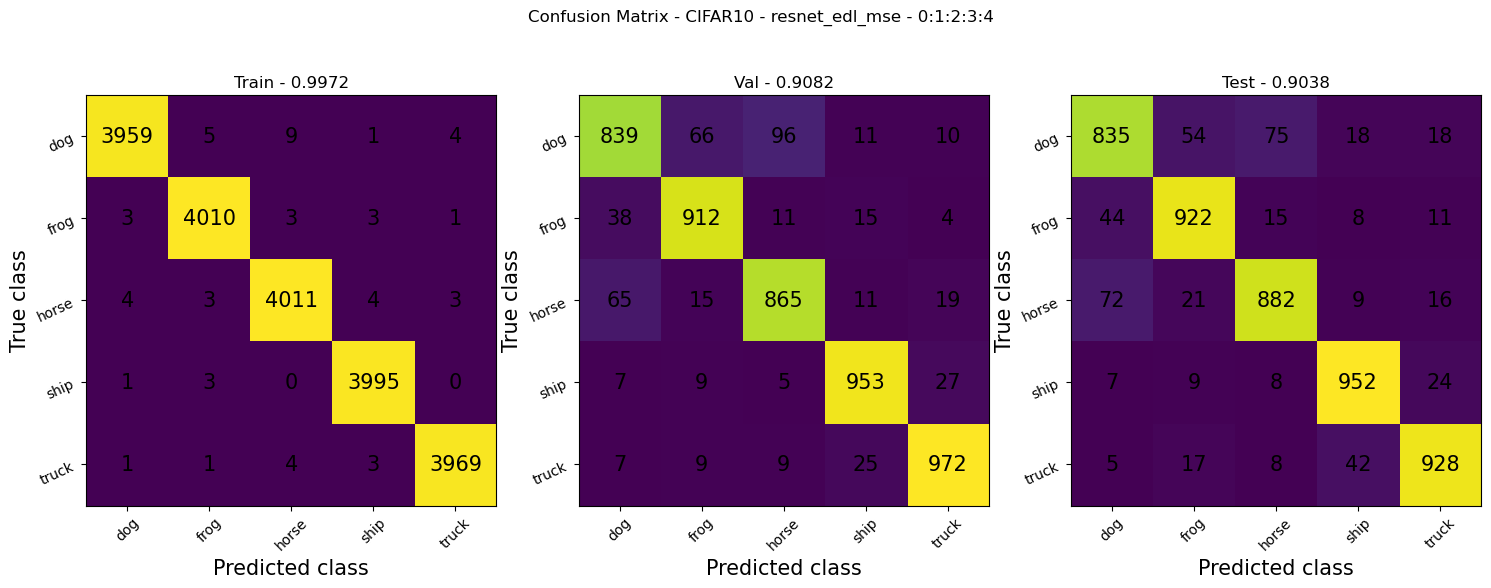

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

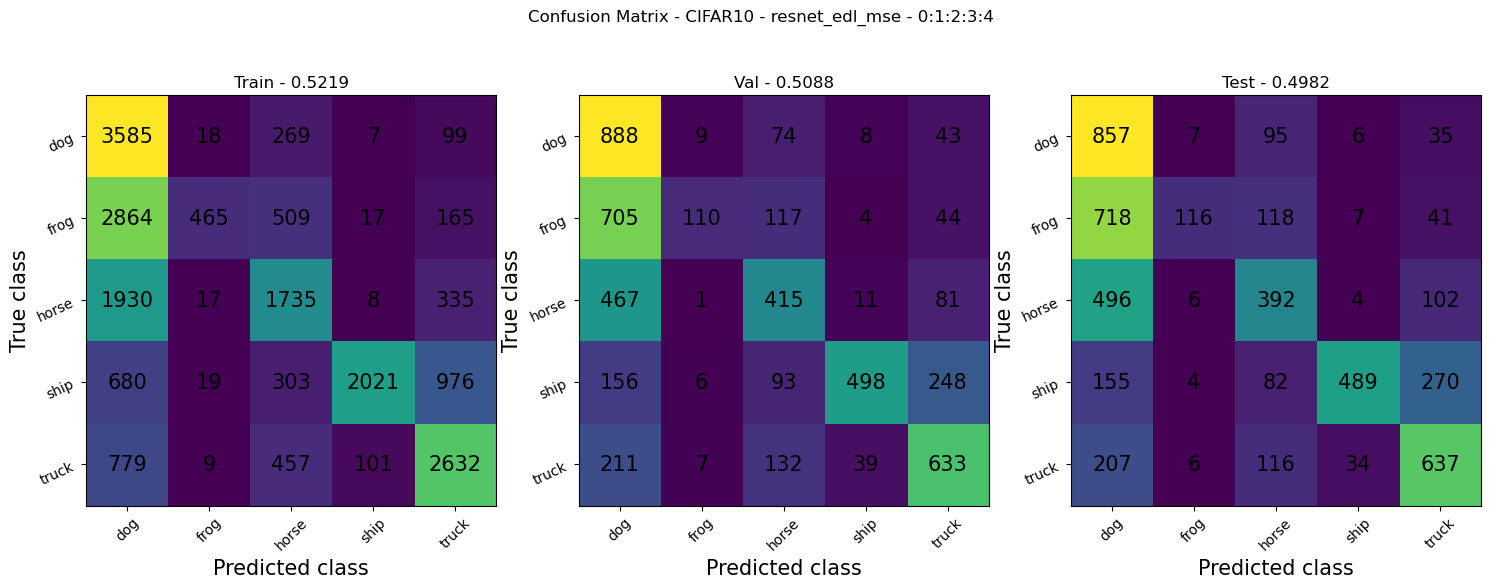

In [12]:
# compute test set accuracy - FPI
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(ftrain_acc=train_acc, fval_acc=val_acc, ftest_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [13]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


In [14]:
# create 2d embeddings - FPI
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


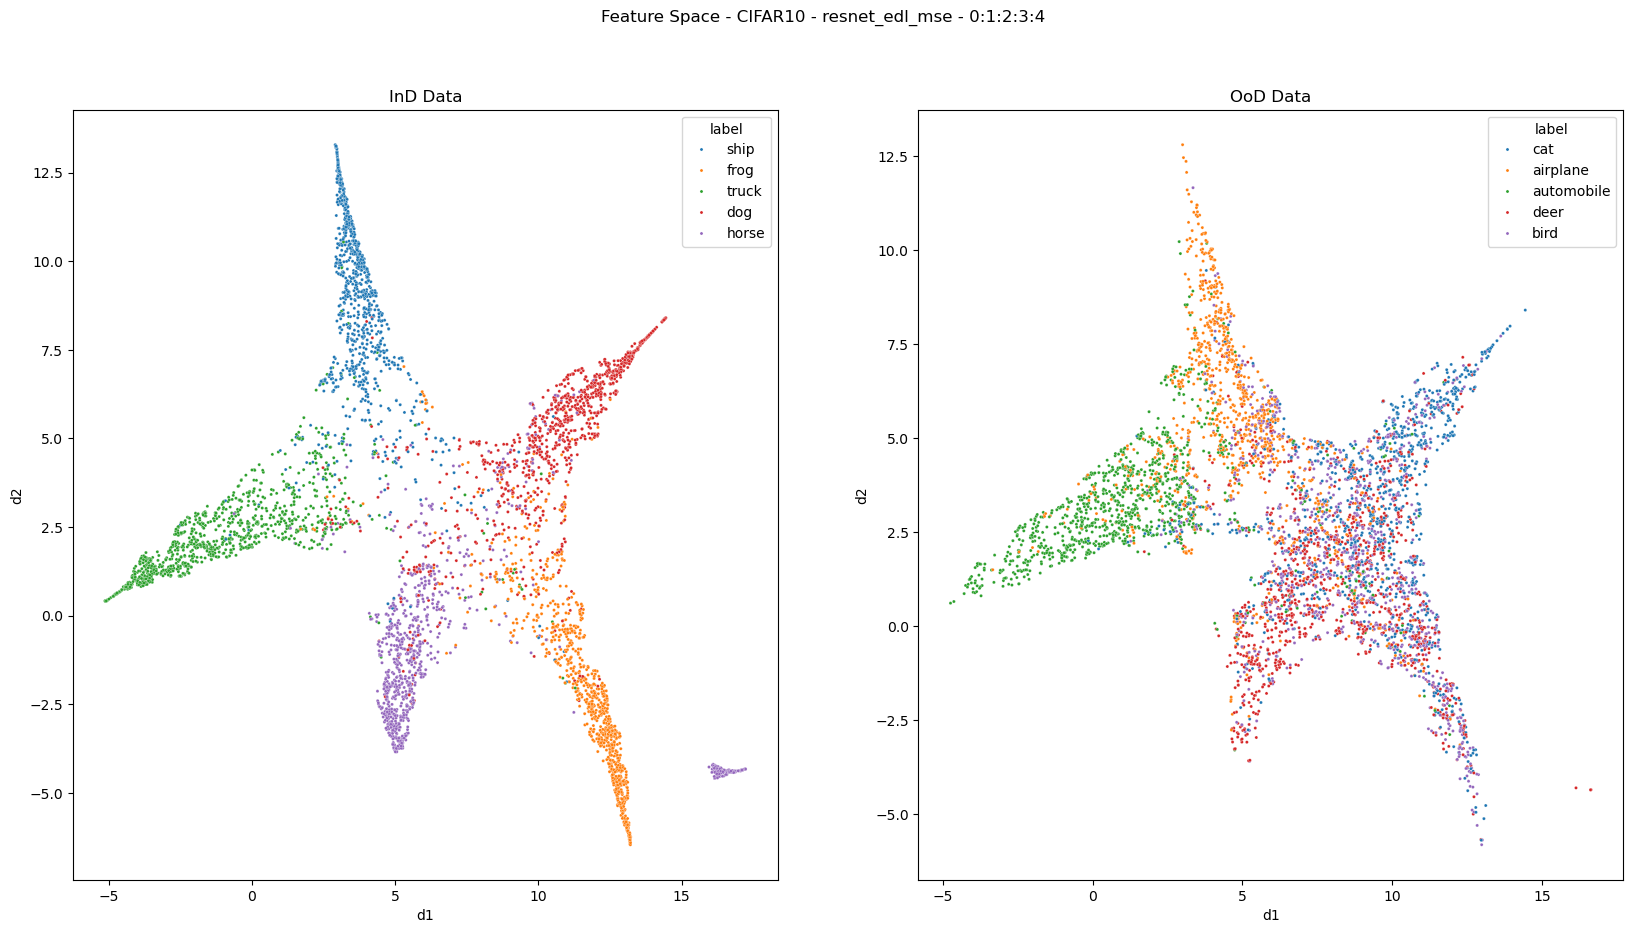

In [15]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

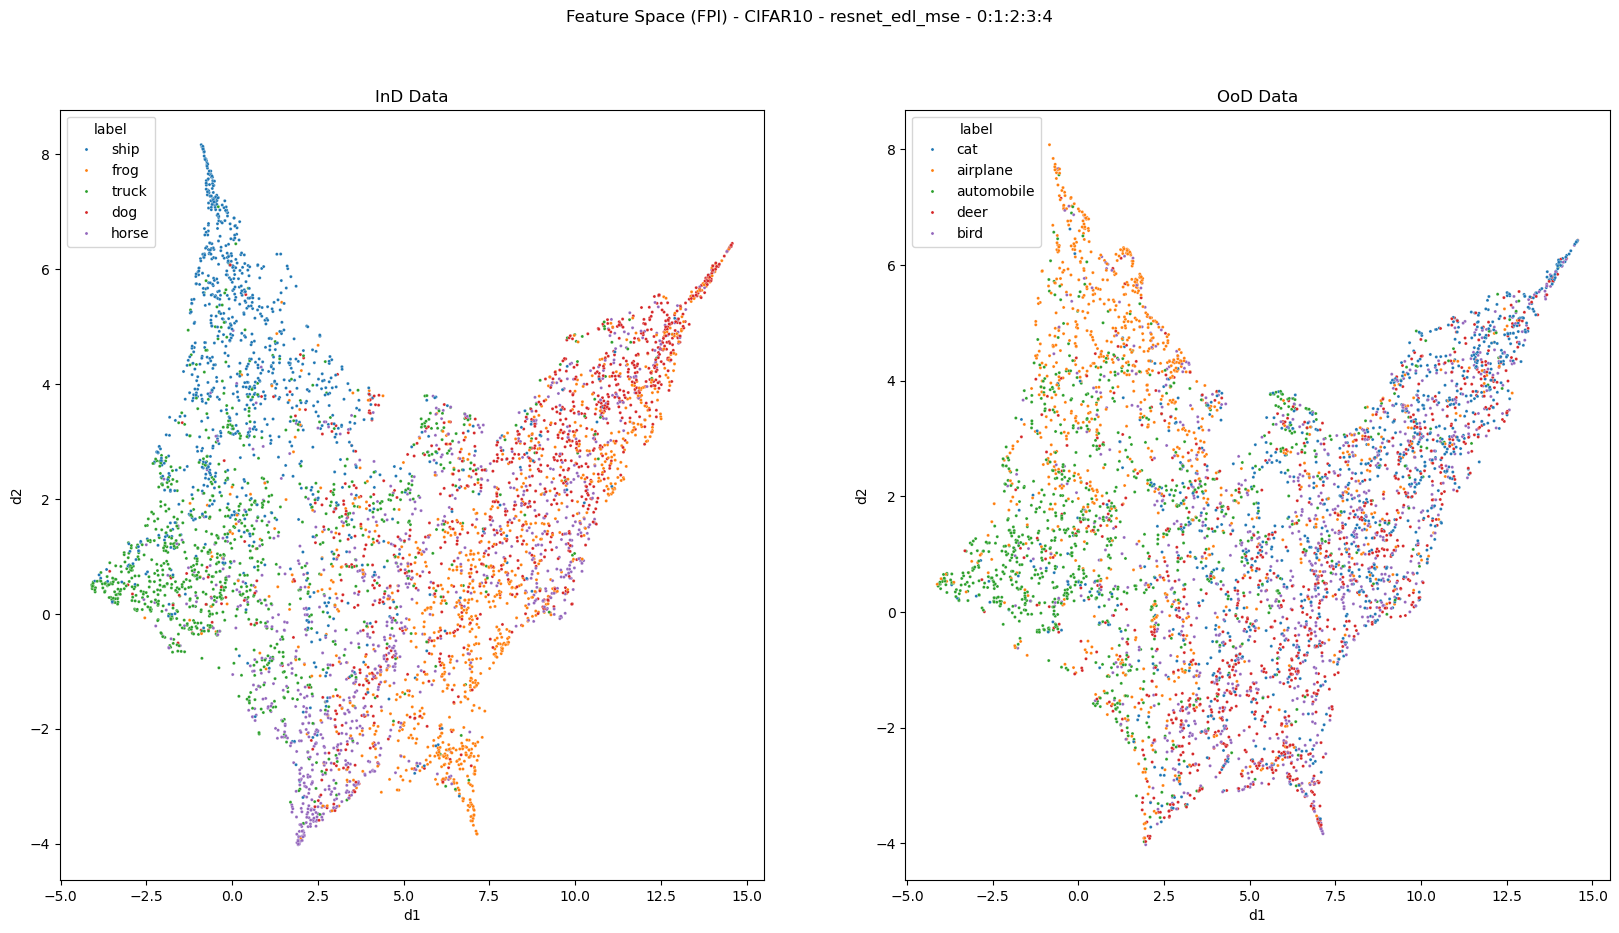

In [16]:
# plot feature space - FPI
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

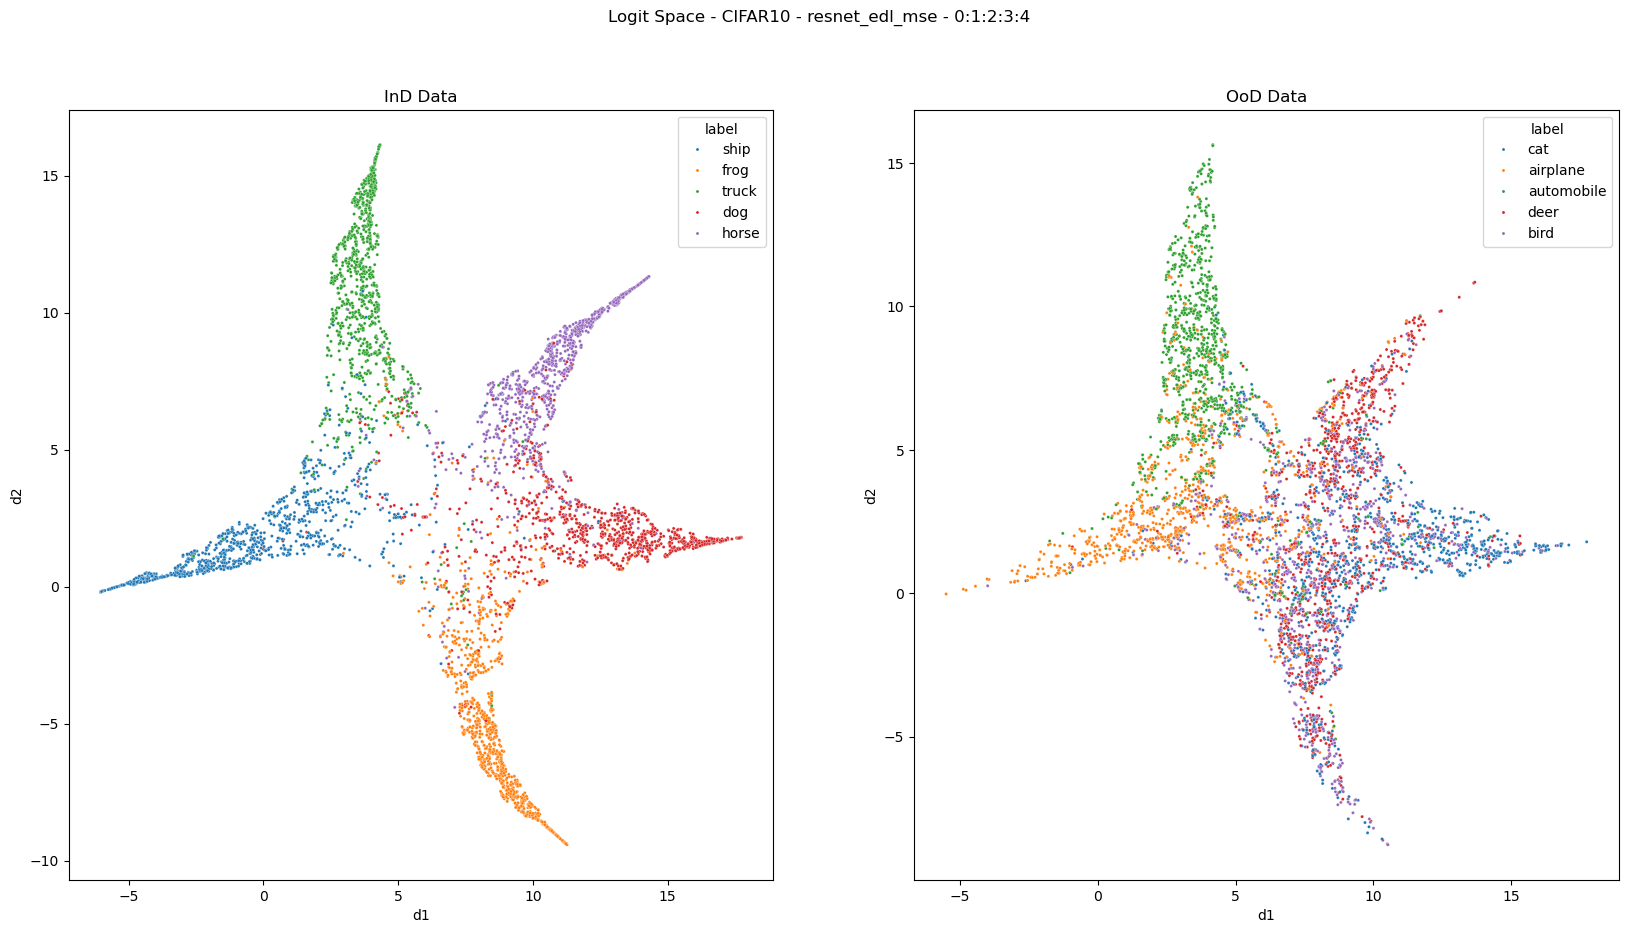

In [17]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

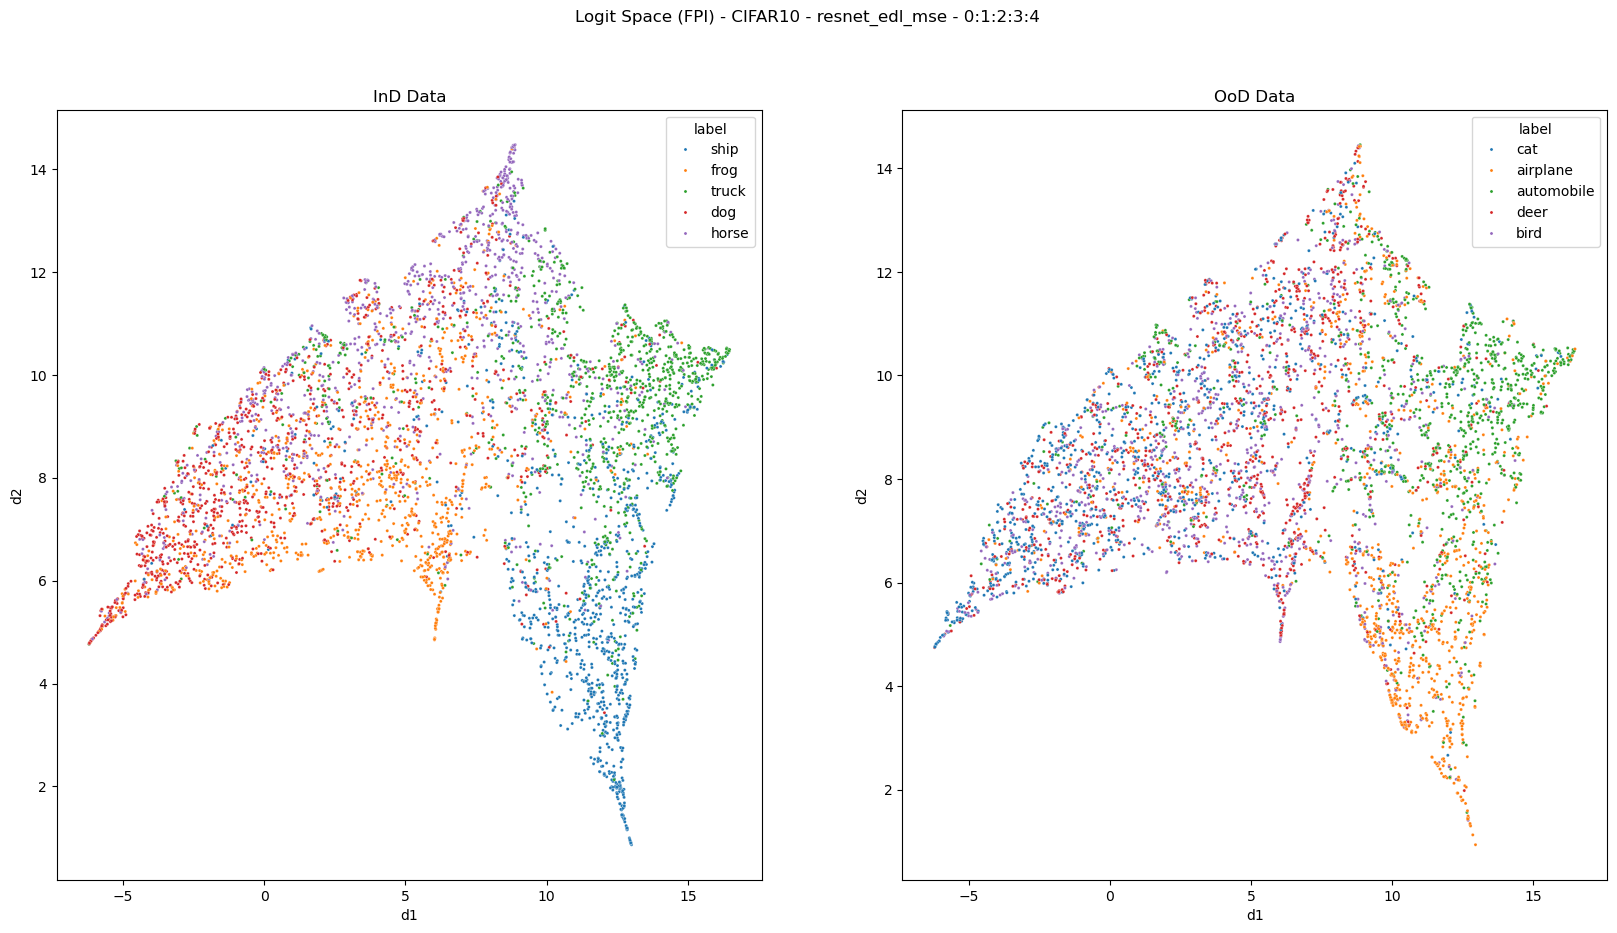

In [18]:
# plot logit space - FPI
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

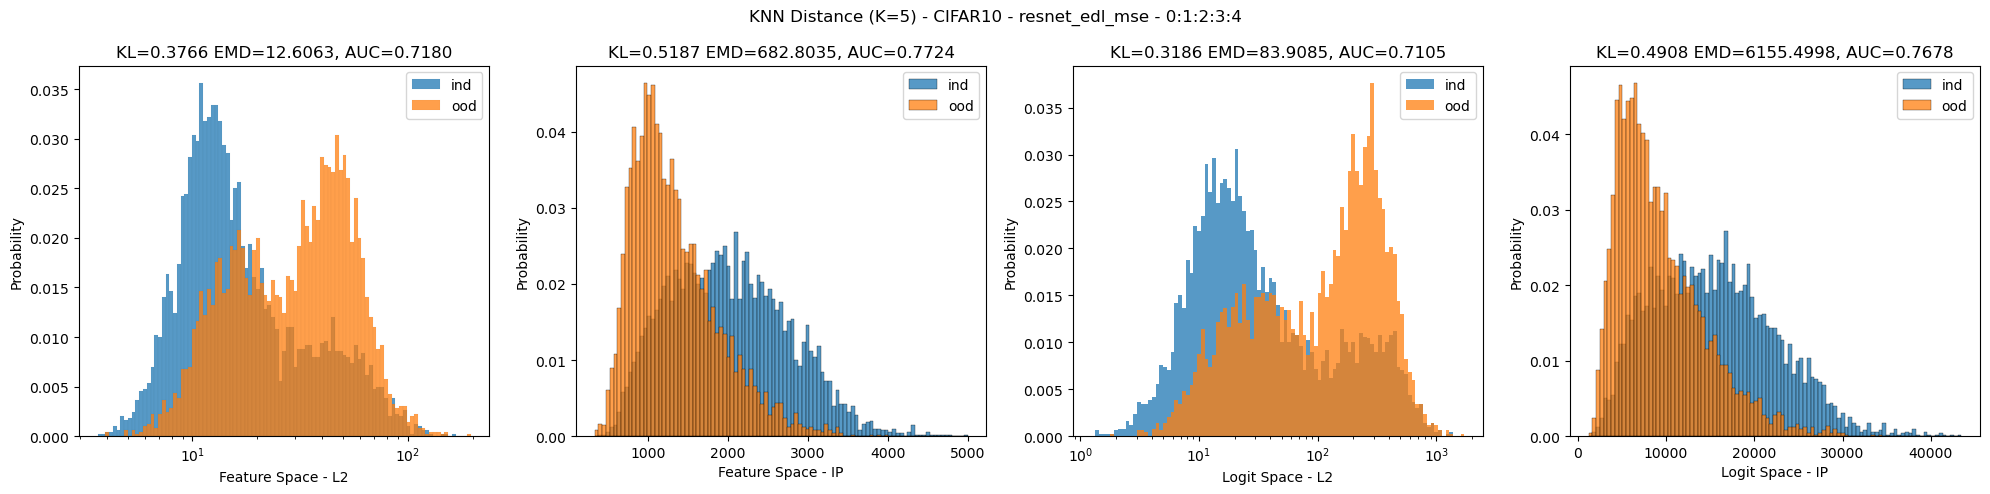

In [19]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

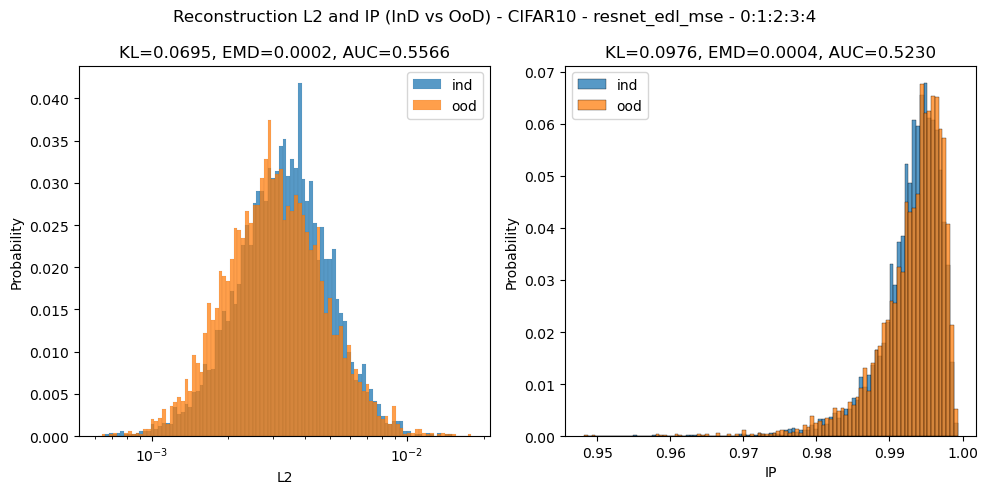

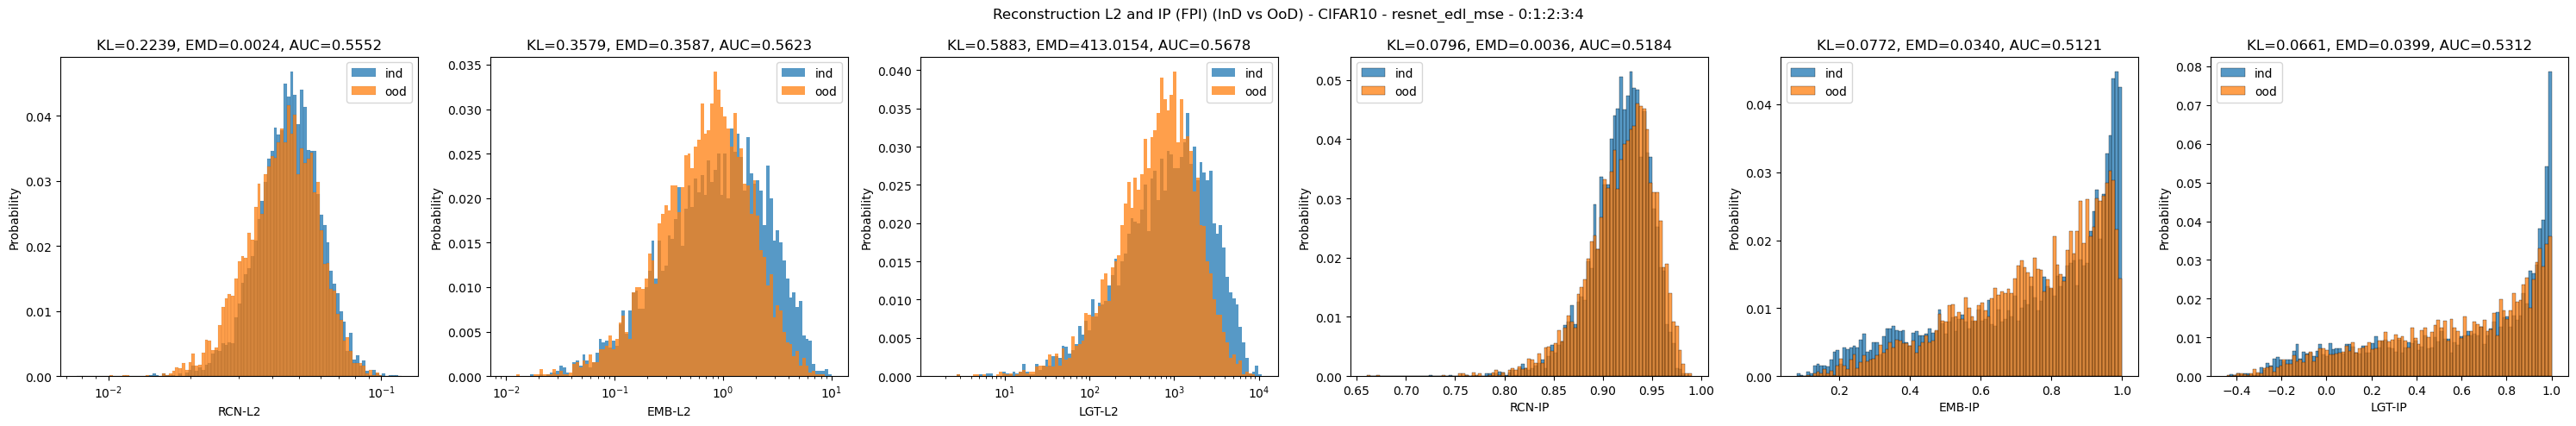

In [20]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# validation data
_val_inp = flatten(val_inp)
_val_rcn, _val_emb, _val_lgt = flatten(val_rcn), flatten(val_emb), flatten(val_lgt)
_val_rcn_fpi, _val_emb_fpi, _val_lgt_fpi = flatten(val_rcn_fpi), flatten(val_emb_fpi), flatten(val_lgt_fpi)
_val_inp_unit = unit(_val_inp)
_val_rcn_unit, _val_emb_unit, _val_lgt_unit = unit(_val_rcn), unit(_val_emb), unit(_val_lgt)
_val_rcn_fpi_unit, _val_emb_fpi_unit, _val_lgt_fpi_unit = unit(_val_rcn_fpi), unit(_val_emb_fpi), unit(_val_lgt_fpi)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)
val_rcn_l2_fpi = ((_val_inp - _val_rcn_fpi) ** 2).mean(-1)
val_emb_l2_fpi = ((_val_emb - _val_emb_fpi) ** 2).mean(-1)
val_lgt_l2_fpi = ((_val_lgt - _val_lgt_fpi) ** 2).mean(-1)
val_rcn_ip_fpi = (_val_inp_unit * _val_rcn_fpi_unit).sum(-1)
val_emb_ip_fpi = (_val_emb_unit * _val_emb_fpi_unit).sum(-1)
val_lgt_ip_fpi = (_val_lgt_unit * _val_lgt_fpi_unit).sum(-1)

# ind test data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # ood test data    
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))
run_stats["frcn_l2"] = plot_rcn(val_rcn_l2_fpi, ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
run_stats["femb_l2"] = plot_rcn(val_emb_l2_fpi, ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
run_stats["flgt_l2"] = plot_rcn(val_lgt_l2_fpi, ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
run_stats["frcn_ip"] = plot_rcn(val_rcn_ip_fpi, ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
run_stats["femb_ip"] = plot_rcn(val_emb_ip_fpi, ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
run_stats["flgt_ip"] = plot_rcn(val_lgt_ip_fpi, ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

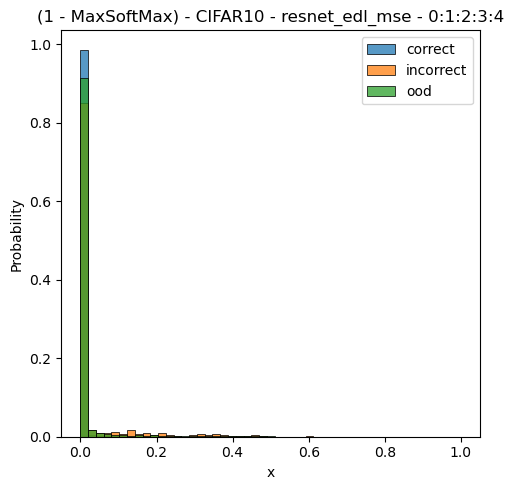

In [21]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

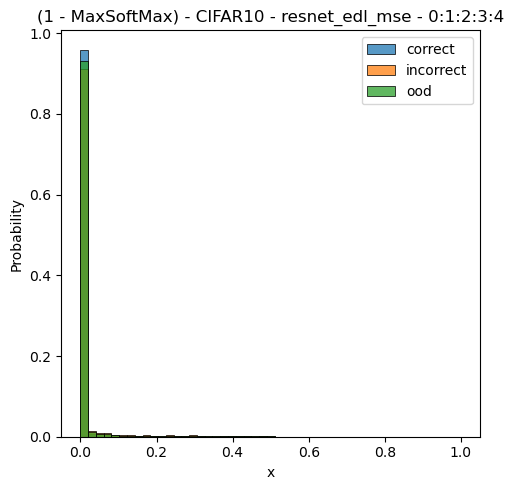

In [22]:
# plot (1 - maxsoftmax) distribution - FPI
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

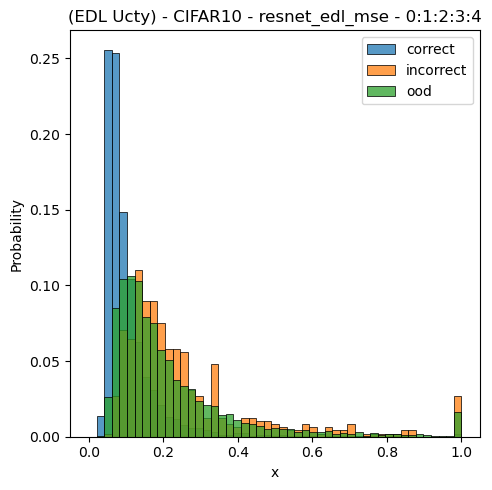

In [23]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

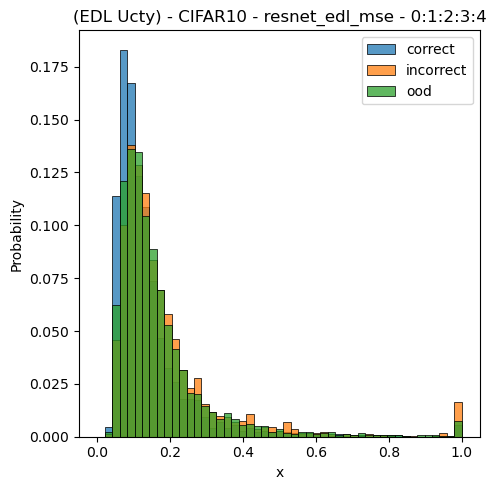

In [24]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data - FPI
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [25]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)